In [677]:
%matplotlib inline
import networkx as nx
import math
import random
from collections import defaultdict
from matplotlib import pyplot as plt

In [678]:
# dataset
X = [[1, 0, 0],
     [1, 0, 1],
     [1, 1, 0], 
     [1, 1, 1]]
y = [-1, 1, 1, -1]

class Activation:
    pass

class Sigmoid(Activation):
    def __call__(self, values):
        return 1 / (1 + math.exp(-sum(values)))

    def gradient(self, weight, activation):
        return activation * (1 - activation)
        
class Tanh(Activation):
    def __call__(self, values):
        return np.tanh(np.sum(values))
    
    def gradient(self, weight, activation):
        return 1 - np.tanh(activation)**2
        
class Linear(Activation):
    def __call__(self, values):
        return sum(values)
    
    def gradient(self, weight, activation):
        return 1
    
class SquaredLoss():
    def __init__(self):
        self.expected = None
    
    def __call__(self, values):
        return (sum(values) - self.expected)**2
    
    def gradient(self, weight, activation):
        return 2 * activation

Create the architecture

In [679]:
G = nx.DiGraph()

# Input nodes
d_input = len(X[0])

input_nodes = []
for i in range(d_input):
    input_node = "x" + str(i)
    input_nodes.append(input_node)
    G.add_node(input_node, activator=Identity())

# Intermediate layer
for i in range(8):
    hidden_node = "h" + str(i)
    G.add_node(hidden_node, activator=Tanh())
    for input_node in input_nodes:
        G.add_edge(input_node, hidden_node)

G.add_node("hb", activation=1.0)

# Output layer
output_node = "y"
G.add_node(output_node, activator=Linear())
for n in G.nodes():
    if n.startswith("h"):
        G.add_edge(n, output_node)

# Bias term
loss_node = "loss"
G.add_node(loss_node, activator=SquaredLoss())
G.add_edge(output_node, loss_node)

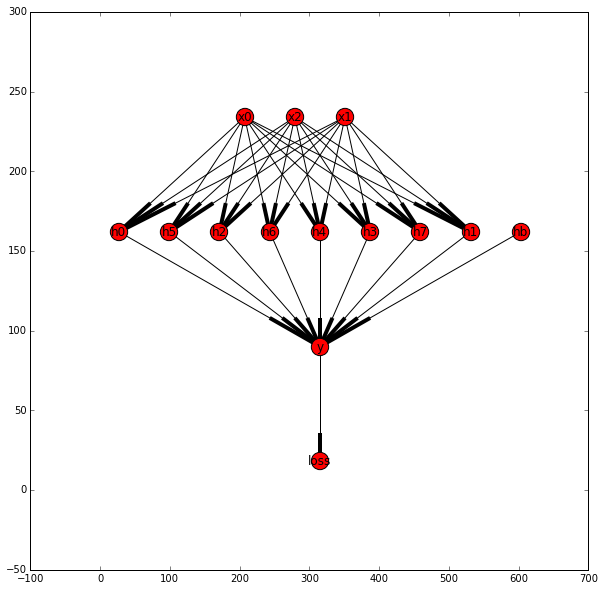

In [680]:
fig, ax = plt.subplots(figsize=(10,10))

layout = nx.graphviz_layout(G, prog='dot')
#nx.draw_graphviz(G, prog='dot')
nx.draw_networkx(G, pos=layout, ax=ax)

In [681]:
weights = defaultdict(lambda: (random.random() - .5) * .1)
weights[('y', 'loss')] = 1
gradients = {}

The backward pass calculates the gradients of each weights with respect to the total function that the neural network represents.

This can be thought of as finding, for each weight, a linear approximation of the NN function, while keeping all of the other parameters fixed. Let $NN(\mathbf{x}, \mathbf{W})$ be function computed by the neural network, $w$ a specific weight in the network, $m = \frac{\partial NN}{\partial w}$

$$g(w) = NN(\mathbf{x}, \mathbf{W}) + m(w - a)$$

In [682]:
def compute_gradients_for_node(G, v):
    # Arguments of the node function
    parents = G.predecessors(v)
    if not len(parents):
        return

    # Assumption: grad cache is already computed when we visit this node
    v_activator = G.node[v]['activator']
    v_activation = G.node[v]['activation'] 
    v_grad_cache = G.node[v].get('grad_cache', 1)
    
    for u in parents:
        # Compute the gradient of edge weight (u, v)
        
        grad_wrt_v = v_activator.gradient(G.node[v]['activation'], G.node[v]['activation']) * G.node[u]['activation']
        grad_wrt_nn = grad_wrt_v * v_grad_cache

        # G.node[u]['activation'] * 
        # Weight sharing here?

        gradients[(u, v)] = grad_wrt_nn
        if 'grad_cache' not in G.node[u]:
            G.node[u]['grad_cache'] = 0
        G.node[u]['grad_cache'] += grad_wrt_nn

In [683]:
def compute_activation_for_node(G, v):
    parents = G.predecessors(v)
    if not len(parents):
        return

    inputs = [G.node[u]['activation'] * weights[(u, v)] 
              for u in G.predecessors(v)]
    if inputs:
        G.node[v]['activation'] = G.node[v]['activator'](inputs)
        #print("At node", v, "activation is", G.node[v]['activation'], " with inputs", inputs)

In [684]:
from sklearn.utils import shuffle


for _ in range(100):
    X, y = shuffle(X, y)

    loss_per_round = 0
    for x, label in zip(X, y):
        for n in nx.nodes(G):
            if 'grad_cache' in G.node[n]:
                del G.node[n]['grad_cache']
                del G.node[n]['activation']
        G.node['hb']['activation'] = 1
        
        # Initialize values of the input nodes
        for i, input_node in enumerate(input_nodes):
            G.node[input_node]['activation'] = x[i]

        # Set the expected value
        G.node[loss_node]['activator'].expected = label

        for n in nx.topological_sort(G):
            compute_activation_for_node(G, n)

        for n in nx.topological_sort(G, reverse=True):
            compute_gradients_for_node(G, n)
            

        for u, v in G.edges():
            if v != 'loss':
                #print((u, v), gradients[(u, v)])
                weights[(u, v)] -= gradients[(u, v)]

        loss_per_round += G.node[loss_node]['activation']

    print(loss_per_round)
        #print(G.node[loss_node]['activation'], G.node['y']['activation'], x, label)
        
        

4.00095190009
3.99368534025
3.89382480673
4.00118141305
3.90386447999
3.99540452491
4.09244116154
3.99358457102
3.90265312391
4.00871666624
3.99941507055
3.87913853293
4.11042007037
3.99317032459
4.20075352031
3.98385717197
3.76782027744
4.20777295879
3.98580380994
3.98643559302
4.00236480295
3.98964568674
3.99277612226
4.00105207865
4.00844322576
3.9926306531
3.98543900025
4.00266518142
3.99146652283
3.8951152879
3.98673452563
3.99936191604
4.18189772233
3.99352454371
3.98903202817
3.99894419036
4.28234676047
3.96411180084
3.97992204938
3.99462803495
4.30411720206
3.97613070049
3.69683995096
4.00270987747
3.99708881868
3.99062231093
3.85302888542
4.00082664119
3.99072570246
4.07304493618
3.91076794894
4.00530663568
4.01472150177
4.04130666935
3.99213776914
4.00711573579
3.96039096862
4.00133065525
3.92904239578
3.99984485307
3.99627002865
4.07500149243
4.10591759451
4.00548762242
4.14849976758
3.98194965075
3.98659901968
3.98716240443
3.88377353389
3.8918618988
4.09746799868
4.1240241

In [685]:
for n in G.nodes():
    print(n)

x0
h1
h0
h5
h2
hb
y
x2
h6
loss
x1
h4
h3
h7


In [686]:
print(dict(weights))


{('x1', 'h6'): 0.012393930064902922, ('h2', 'y'): 0.044567094546005305, ('y', 'loss'): 1, ('x1', 'h7'): -0.0010568464426020045, ('x1', 'h1'): -0.001039033474095302, ('x1', 'h4'): -0.02769862631113244, ('x0', 'h2'): 0.012279879813481788, ('h0', 'y'): 0.00077746027220362, ('x2', 'h6'): 0.026586539658864924, ('x0', 'h5'): 0.016557582242845304, ('h5', 'y'): -0.02111595854103018, ('h1', 'y'): -0.032374766962756138, ('x2', 'h0'): -0.00054812639914807735, ('h4', 'y'): 0.019183642146056074, ('x0', 'h1'): 0.048352479269552037, ('x0', 'h3'): -0.0034670211550040823, ('x2', 'h3'): 0.010800723588686003, ('h7', 'y'): -0.078252152644752701, ('x2', 'h4'): 0.041795292156191113, ('x0', 'h0'): 0.026531259480620122, ('x1', 'h2'): -0.0080833748231080669, ('x1', 'h0'): -0.031907912623837686, ('x2', 'h1'): -0.043883526309316009, ('x1', 'h5'): -0.030522049239964537, ('h3', 'y'): -0.012985373083932519, ('h6', 'y'): 0.010651064804758015, ('x1', 'h3'): -0.013174624867269344, ('hb', 'y'): 0.011106435470693794, ('

In [687]:
[(u, G.node[u]) for u, _, edge in G.in_edges('h1', data=True)]

[('x0',
  {'activation': 1,
   'activator': <__main__.Identity at 0x109749fd0>,
   'grad_cache': -0.0016242282150773051}),
 ('x1',
  {'activation': 0,
   'activator': <__main__.Identity at 0x10a14a6a0>,
   'grad_cache': 0.0}),
 ('x2',
  {'activation': 1,
   'activator': <__main__.Identity at 0x10a14a940>,
   'grad_cache': -0.0016242282150773051})]

In [688]:
G['x1'].keys()

dict_keys(['h7', 'h3', 'h0', 'h5', 'h2', 'h6', 'h4', 'h1'])

In [689]:
nx.topological_sort(G, reverse=True)

['loss',
 'y',
 'h1',
 'h4',
 'h6',
 'h2',
 'h5',
 'h0',
 'h3',
 'h7',
 'x0',
 'hb',
 'x2',
 'x1']

In [690]:
G.predecessors('x0')

[]